# Upper Confidence Bound 

Reference: 

https://zhuanlan.zhihu.com/p/32335683

Note all contents are included.

In [1]:
import numpy as np 
import pandas as pd 
from scipy import stats

# visualizatioion pkg 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format='retina'

from utils.viz import viz 
viz.get_style()

### Bandit problem

Inside a Casino, there are N bandit machines. 

If you pull a bandit machine, it returns either 1 dollar or nothing. We are told that different machines have different rewarding probabilities but have no idea of the exact values. 

How to maximize our reward within T attempts? 

In [2]:
def bandits(agent, params, seed=1234, N=20, T=10000):
    
    rng      = np.random.RandomState(seed)
    p_True   = rng.uniform(low=0, high=1, size=N)
    subj     = agent(N, params)
    rew_hist = []

    for _ in range(T):

        # pull a machine and get reward 
        a = subj.get_act(rng)
        r = rng.binomial(n=1, p=p_True[a])
        rew_hist.append(r)
        subj.update(a, r)

    return np.array(rew_hist)

The simplest way is to randomly pick actions

In [3]:
class rand:
    name = 'random'

    def __init__(self, nA, params):
        self.nA = nA
        self._load_params(params)

    def _load_params(self, params):
        pass
        
    def get_act(self, rng):
        return rng.choice(range(self.nA)) 

    def update(self, a, r):
        pass 

In [4]:
def sim(agent, params, n_sim=20, seed=1234):
    avg_rew_hist = 0 
    for _ in range(n_sim):
        seed += 1
        avg_rew_hist += bandits(agent, params, seed) / n_sim
    return avg_rew_hist

In [37]:
def viz_reward(agents, params, win_sz=40, n_sim=80): 
    rew_hists = [] 
    for agent, param in zip(agents, params):
        rew_hist = sim(agent, param, n_sim=n_sim)
        # simple moving average
        rew_hist = pd.Series(rew_hist).rolling(win_sz
                    ).mean().values[win_sz-1:]
        rew_hists.append(rew_hist)
    ts = np.arange(1, len(rew_hist)+1)
    plt.figure(figsize=(8, 4))
    for j, rew_hist in enumerate(rew_hists):
        sns.lineplot(x=ts, y=rew_hist, 
                    lw=3, color=viz.Palette[j])
    plt.legend([agent.name for agent in agents])
    plt.ylim([.4, 1])
    plt.ylabel('reward')
    plt.xlabel('time')
    plt.title(f'{agent.name}, {n_sim} sim. \nsmooth win {win_sz}')

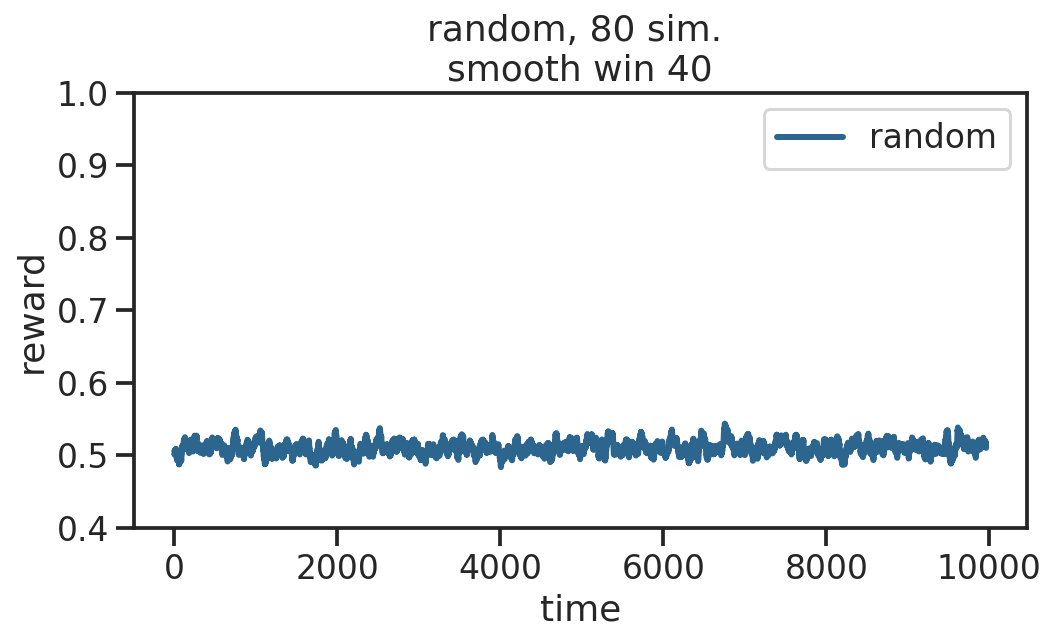

In [38]:
viz_reward([rand], params=[[]])

We can see, if we just pick the slot machines randomly, the expected reward will eventually converge on 50%. Any way to improve the picking strategy?

### Greedy method

A strategy forward way is to model the rewarding probability of each machine. And then each time we choose the machine we believe the best.

In [39]:
class greedy(rand):
    name = 'greedy'

    def __init__(self, nA, params):
        super().__init__(nA, params)
        self.v_SA  = np.ones([nA]) / nA

    def _load_params(self, params):
        self.alpha = params[0]

    def update(self, a, r):
        v_Hat = self.v_SA[a]
        self.v_SA[a] += self.alpha*(r - v_Hat)

    def get_act(self, rng):
        return np.argmax(self.v_SA)

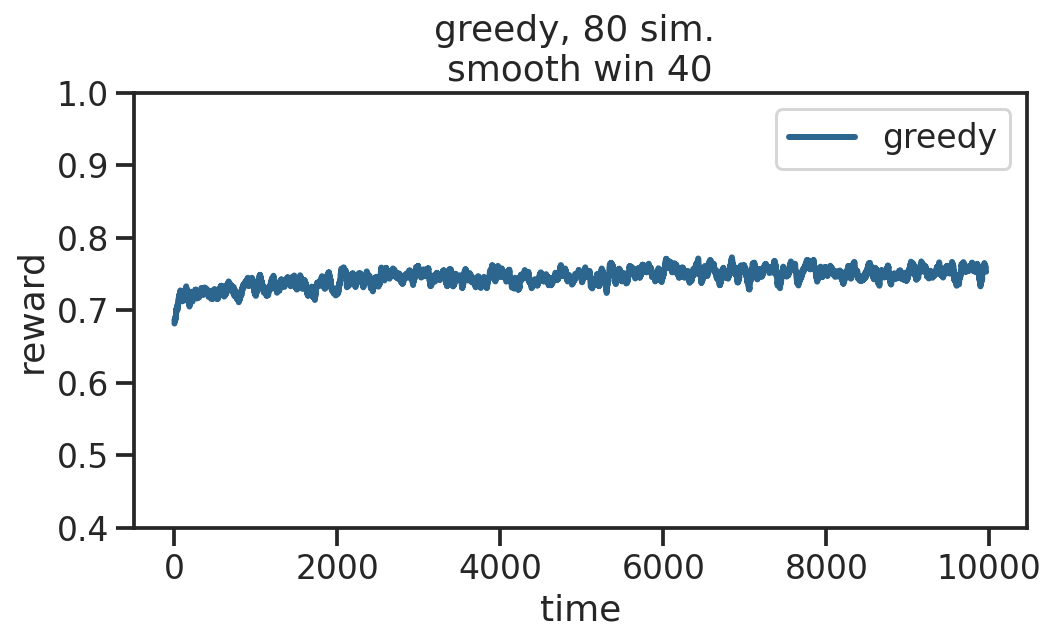

In [40]:
params=[.1]
viz_reward([greedy], [params])

But... this does not match our expectations. This is true that the greedy method improves the expected reward, but it seems to be stuck at the plateau of 0.7. What is wrong? People consider this issue the explore-exploitation problem. The greedy strategy is correct only when the learned belief equals the ground truth. When the agent believes the world incorrectly, the greedy strategy will force the agent to repeat the subjective-best but objective-incorrect action blindly, having no chance to recognize the faults of his beliefs. This is the issue of exploiting the belief. Hence, we need some exploration to correct the wrong belief. 

The simplest way is $\epsilon$-greedy, adding exploration in a fit probability of $\epsilon$. 

In [41]:
class egreedy(greedy):
    name = 'e-greedy'

    def _load_params(self, params):
        self.alpha = params[0]
        self.eps   = params[1]

    def get_act(self, rng):
        if rng.rand() < self.eps:
            a = rng.choice(range(self.nA)) 
        else: 
            a = np.argmax(self.v_SA)
        return a 

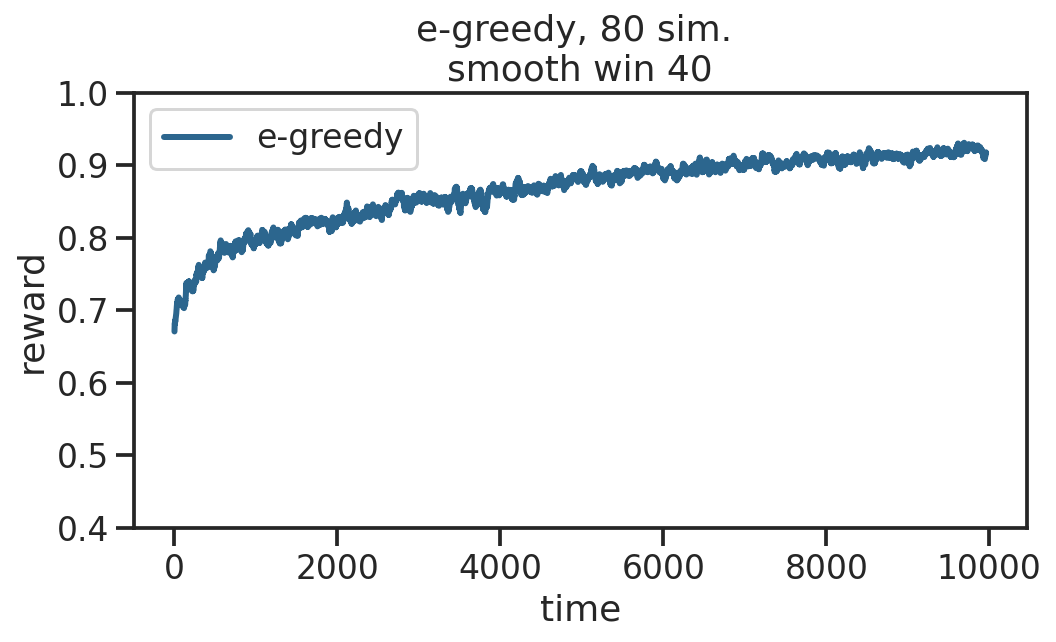

In [42]:
params=[.1, .01]
viz_reward([egreedy], [params])

It's easy to see that the $\epsilon$ exploration method breaks the .7 celling of the greedy method, reaching an expected reward of 0.9.

## Thompson sampling

The e-greedy method greatly improves decision-making performance. However, this is only a heuristic method while we always want to derive the principled best exploration-exploitation balance. Hence, we need to model the value using probabilistic distributions.

In [45]:
class TS(rand):
    name = 'Thompson sampling'

    def __init__(self, nA, params):
        super().__init__(nA, params)
        self.hits   = np.ones([nA,])*self.a 
        self.falses = np.ones([nA,])*self.a

    def _load_params(self, params):
        self.a = params[0]
        
    def get_act(self, rng):
        v_A = rng.beta(self.hits, self.falses)
        return np.argmax(v_A)

    def update(self, a, r):
        self.hits[a]   += r
        self.falses[a] += (1-r)

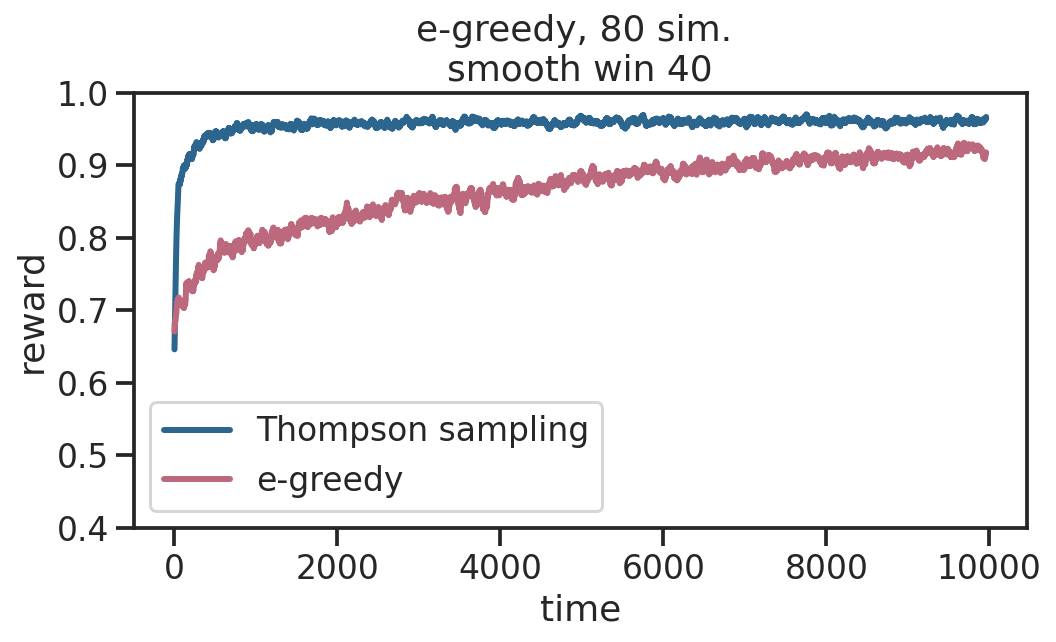

In [46]:
params=[[.1], [.1, .01]]
viz_reward([TS, egreedy], params)

With a probabilistic model of bandit machines, an agent can perform much better than those who use the heuristic e-greedy strategy.

## Upper Confidence Bound

What is the problem with using a probabilistic model? Maintaining a probabilistic distribution is usually computationally expensive, especially when the variables have a huge state space. To tradeoff the computational expense and accuracy, we are thristy for a principled method that optimize the exploration-exploitation balance without introducing any probabilistic distribution. This motivate the UCB method. 

When estimating the mean of a data set, there is always a discrepancy between the sample mean $E[x]$ and ground truth $\mu$.

$$\Delta = E[x] - \mu$$

As we know, this gap can be reduced by increasing the number of samples. The Chernoff-Hoeffding Bound formalizes the relationship between the $Delta$ and the sample size $n$ as,

$$Pr\{|\Delta|\leq\delta\} \geq 1 - 2\exp(-2n\delta^2)$$

meaning the probability of getting a acceptable estimation ($|\Delta|\leq\delta$) is at least $1 - 2\exp(-2n\delta^2)$. let $\delta = \sqrt{2 \ln T/n}$, where T is the total attempts. (Why $ \sqrt{2 \ln T/n}$? I naively believe it as a way to simplify the expression, cancelling the effect of $n$ and conditioning the whole probability on the current total attempts $T$) The equation is reduced to,

$$Pr\{|\Delta|\leq \sqrt{2 \ln T/n}\} \geq 1 - 2T^{-4}$$

meaning the confidence interval is satisfied at the probability of $1 - 2T^{-4}$. 

$$E[x] - \sqrt{2 \ln T/n} \leq \mu \leq E[x]+\sqrt{2 \ln T/n}$$

Let's have a look at the probability curve. 

Text(0, 0.5, 'P(Correct)')

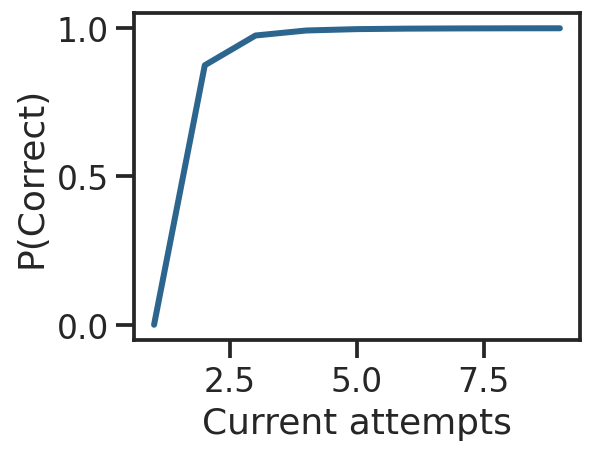

In [67]:
T = np.arange(1, 10)
relu = lambda x: x*(x>0)

plt.figure(figsize=(4, 3))
sns.lineplot(x=T, y=relu(1-2/(T**4+1e-12)), 
                lw=3, color=viz.Blue)
plt.xlabel('Current attempts')
plt.ylabel('P(Correct)')

Even when there are only two attempts, the confidence interval is satisfied at the probability of .875. Back to the main question: we want to find a bonus expression that encourages exploration. It is easy to find that the upper bound is an ideal candidate; the upper interval serves as the bonus terms. When $n$ is small, the bonus term is large, encouraging the exploration; as $n$ increases, the upper confidence bound converges to the true expected reward. 

In [68]:
class UCB(greedy):
    name = 'UCB'

    def __init__(self, nA, params):
        super().__init__(nA, params)
        self.v_A   = np.ones([nA]) / nA
        self.n_A   = np.zeros([nA]) / nA
        self.delta = np.ones([nA])
        self.T     = 0

    def _load_params(self, params):
        self.alpha = params[0]

    def update(self, a, r):
        v_Hat = self.v_A[a]
        self.v_A[a] += self.alpha*(r - v_Hat)
        self.n_A[a] += 1 
        self.T += 1
        d = np.sqrt(2*np.log(self.T+1e-12))/(self.n_A+1e-12)
        self.delta = np.clip(d, 0, 1)
       
    def get_act(self, rng):
        return np.argmax(self.v_A + self.delta)

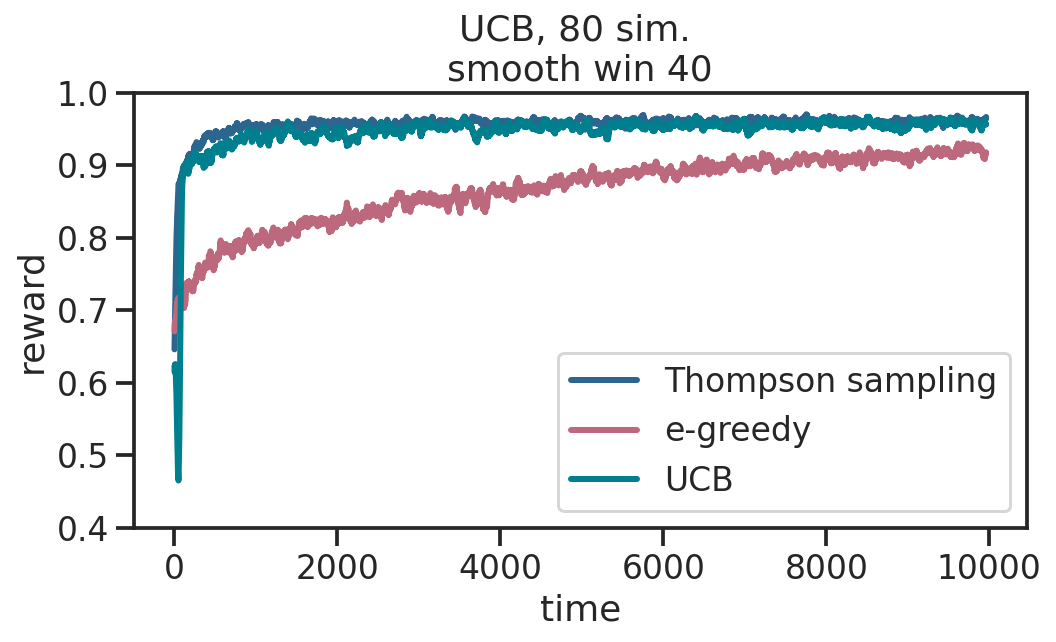

In [70]:
params=[[.1], [.1, .01], [.1]]
viz_reward([TS, egreedy, UCB], params)

The performance UCB method is between the principled TS and e-greedy method without a probabilistic model. However, the improvement from the UCB to the TS method is subtle.  

##